<h1>Compare Real and Complex Source Separation Performance</h1>
<h2>Michael A. Casey - Bregman Labs - Dartmouth College</h2>

In [ ]:
from pylab import *
from bregman.suite import *
import cseparate as cs
%matplotlib inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [ ]:
help(cs.cseparate) # COMPLEX MATRIX FACTORIZATION

In [ ]:
help(plca.PLCA.analyze) # REAL MATRIX FACTORIZATION

In [ ]:
x,sr,fmt = wavread('amen.wav')

In [11]:
def rc_err(x, reduce_mse=True, normalize_recon=True, nfft=4096, ncomps=range(2,13)):
    """
    Compare real and complex spectrum factorization and reconstruction with Mean Square Error.
    inputs:
        x - the one-dimensional audio signal to factorize via its spectrum
        reduce_mse - whether to take the MSE (True) or the SE (False) for each evaluation [True]
        normalize_recon - normalize reconstruction spectra prior to MSE/SE calculation [True]
        nfft - fft size [4096]
        ncomps - list of number of components to test [range(2,13)]
    outputs:
        real_err - list of Real MSE (default) or SE spectra (reduce_mse=False)
        cmplx_err -list of Complex MSE (default) or SE spectra (reduce_mse=False)
    """
    x = x-x.mean() # center the original signal
    x = x/abs(x).max() # normalize the original signal
    real_err, cmplx_err = [],[] # result lists
    N=nfft;W=N/2;H=N/4 # FFT parameters
    # ORIGINAL SPECTRUM (normalized)
    Xo = LinearFrequencySpectrum(x, nfft=N, wfft=W, nhop=H)
    oX = Xo.X # grab the real magnitude spectrum
    if normalize_recon:
        oX = feature_scale(oX, normalize=1) # ORIGINAL |STFT| normalized
    for K in ncomps: # n_components    
        # REAL RECONSTRUCTION (normalized)
        Xr = LinearFrequencySpectrum(x, nfft=N, wfft=W, nhop=H)
        Xr.separate(cls=PLCA, n=K) # real separation (PLCA)
        # REAL ERROR
        rX = array(Xr.X_hat)[:,:,:oX.shape[1]].sum(0) # Real spectral components summed
        if normalize_recon:
            rX = feature_scale(rX, normalize=1) # Normalize
        sqerr_real = (oX - rX)**2
        # COMPLEX RECONSTRUCTION (normalized)
        xci, xc = cs.cseparate(x,K,N,H,W) # complex separation (CJADE)
        xc = xc-xc.mean() # center
        xc = xc/abs(xc).max() # normalize
        Xc = LinearFrequencySpectrum(xc, nfft=N, wfft=W, nhop=H)
        # COMPLEX ERROR
        cX = Xc.X[:,:oX.shape[1]] # Complex spectral components already summed by cseparate
        if normalize_recon:
            cX = feature_scale(cX, normalize=1)
        sqerr_cmplx = (oX - cX)**2
        # Append Results
        cmplx_err.append(sqerr_cmplx)
        real_err.append(sqerr_real)
    if reduce_mse:
        real_err = [r.mean() for r in real_err]
        cmplx_err = [c.mean() for c in cmplx_err]            
    return real_err, cmplx_err

In [12]:
# Run the experiment
real_err,cmplx_err = rc_err(x) 

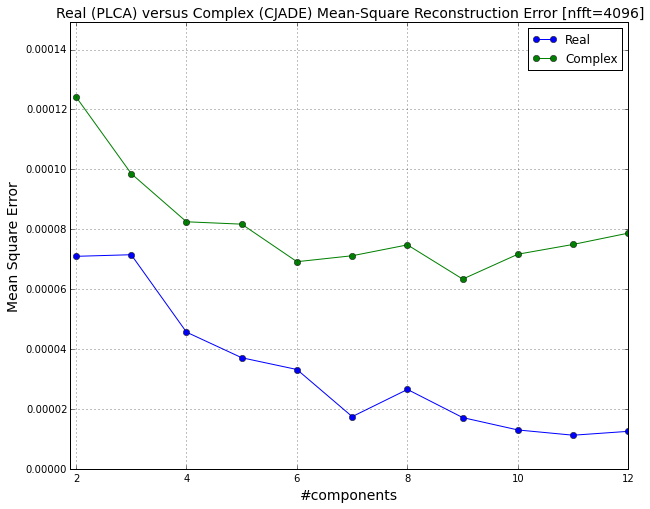

In [15]:
# Plot the results of the experiment
plot(range(2,13),real_err,'-o')
plot(range(2,13),cmplx_err,'-o')
title('Real (PLCA) versus Complex (CJADE) Mean-Square Reconstruction Error [nfft=4096]', fontsize=14)
ylabel('Mean Square Error', fontsize=14)
xlabel('#components', fontsize=14)
legend(['Real','Complex'])
axis(xmin=1.9, ymax=max(max(real_err),max(cmplx_err))*1.2) # Autoscale y axis
grid()